<h2><center> 2D Tomography Reconstruction using CIL </center></h2>
<h3><center> Photoacoustic Backprojection Solutions </center></h3>


In [135]:
# Import libraries

from cil.framework import  AcquisitionGeometry

from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
#from cil.optimisation.algorithms import PDHG
from cil.optimisation.algorithms import CGLS, SIRT, PDHG
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.recon import FDK as FDKTigre
from cil.plugins import TomoPhantom
#from cil.utilities.display import show2D, show_geometry
from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities import noise

from cil.utilities.jupyter import islicer
from cil.optimisation.operators import IdentityOperator
from cil.optimisation.functions import L2NormSquared, L1Norm

import matplotlib.pyplot as plt

import numpy as np

# TIGRE
from cil.recon import FDK as FDKTigre
from cil.plugins.tigre import ProjectionOperator as ProjectionOperatorTigre
from cil.plugins.tigre import FBP as FBPTigre

# Astra
from cil.plugins.astra.processors import FBP as FBPAstra
from cil.plugins.astra.operators import ProjectionOperator as ProjectionOperatorAstra


We first configure our acquisition geometry, e.g., **2D parallel geometry**. Then, the image geometry is extracted and used to configure our phantom. To create our simulated phantoms, we use the [Tomophantom](https://github.com/dkazanc/TomoPhantom) library.

In [136]:
# Detectors
N = 256
detectors =  N

# Angles
# angles = np.linspace(0,180,180, dtype='float32') # This works well for NEXUS!
# print(angles) #

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D(detector_position=[0,0])\
    .set_panel(num_pixels=256)\
    .set_angles(angles=range(0,360,2))
#ag = AcquisitionGeometry.create_Parallel2D(detector_position=[0,0])\
#    .set_panel(num_pixels=256)\
#    .set_angles(angles=range(0,360,2))
#print(ag.angles)

# ag = AcquisitionGeometry.create_parallel2D()
# ag.set_panel(detectors, pixel_size=0.1) # ag.set_panel(num_pixels)
# angles = np.linspace(0,180,180, dtype='float32') # This works well for NEXUS!
# ag.set_angles(angles) # 
#angle_array = np.linspace(0,180,180, dtype='float32')
#ag.set_angles(angle_array, angle_unit="degree")

# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
#phantom = TomoPhantom.get_ImageData(12, ig)

### Load Dataset

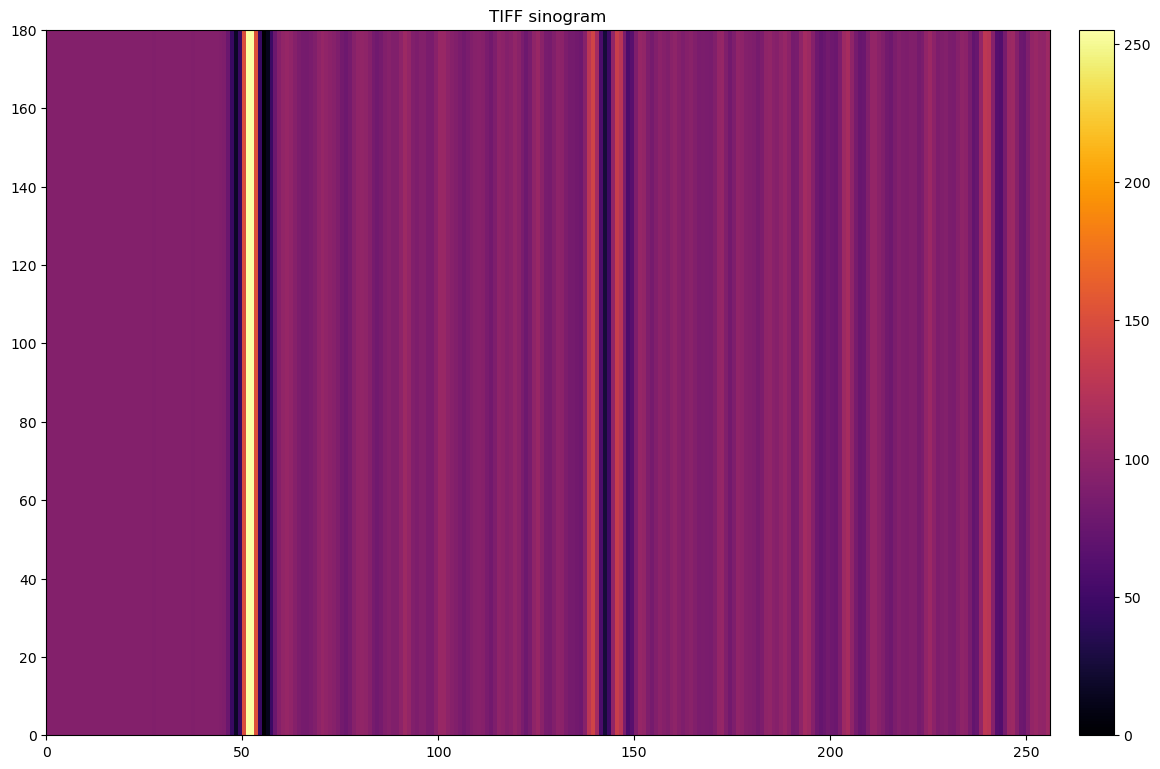

In [137]:
from cil.io import TIFFStackReader
readerTIFF = TIFFStackReader("sino-cobre-p3.tiff") # "TIFF_sinogram_idx_0000.tiff"

sinoTIFF = readerTIFF.read()


# Method 1
# reader = TIFFStackReader("sino.tif")
# data = reader.read_as_AcquisitionData(ag)

# Method 2
# reader = TIFFStackReader("TIFF_sinogram_idx_0000.tiff")
# data_array = reader.read()
# data = AcquisitionData(data_array, geometry=ag, deep_copy=False)


# from cil.io import NEXUSDataReader
# readerNEXUS = NEXUSDataReader("NEXUS_sinogram.nxs")

# sinoNEXUS = readerNEXUS.read()
# 5

#show2D([sinoTIFF,sinoNEXUS], title = ['TIFF sinogram','NEXUS sinogram'], num_cols=2, cmap = 'inferno')
show2D([sinoTIFF], title = ['TIFF sinogram'], num_cols=1, cmap = 'inferno')
# show2D([data], title = ['TIFF sinogram'], num_cols=1, cmap = 'inferno')

For our first reconstruction, we use the Filtered BackProjection algorithm, i.e., `FBP` applied to our noisy sinogram `noisy_sino`.

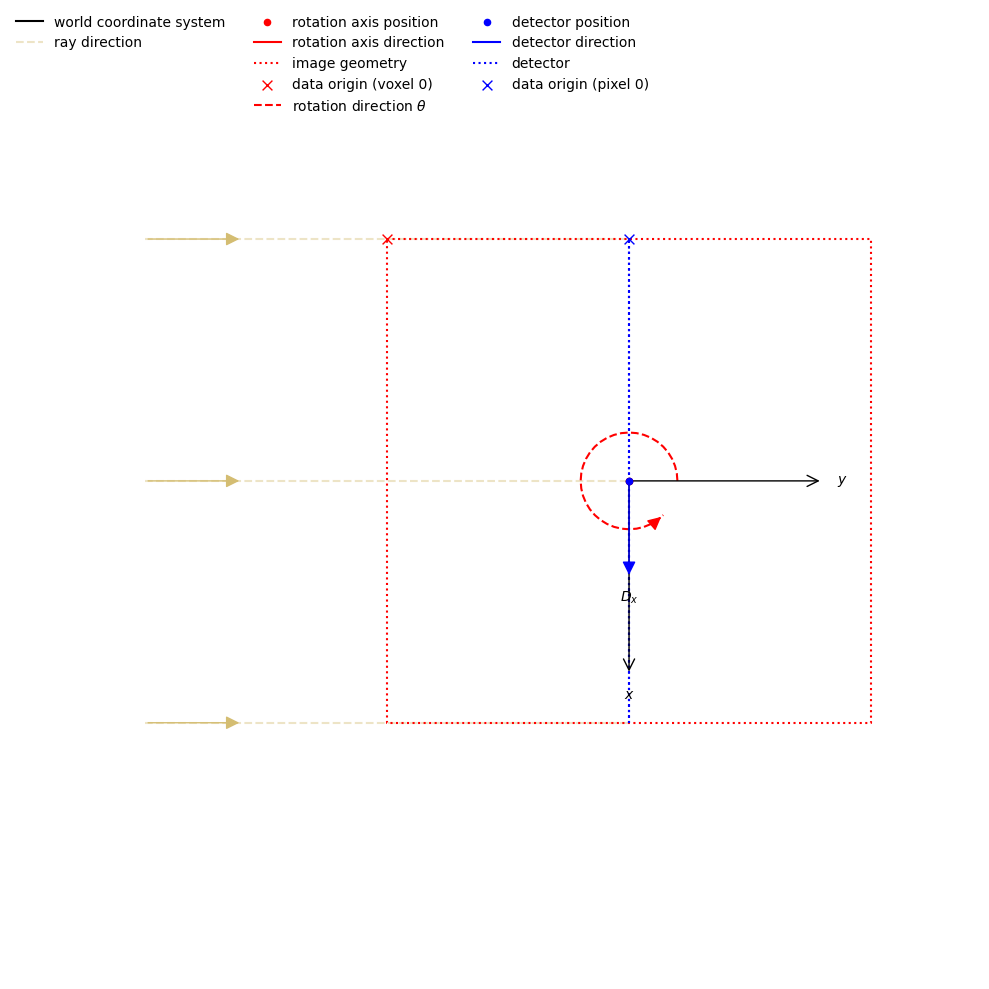

In [138]:
from cil.framework import AcquisitionData

dataTIFF = AcquisitionData(sinoTIFF, geometry=ag)
#dataNEXUS = AcquisitionData(sinoNEXUS, geometry=ag)

ig = ag.get_ImageGeometry()
ig.voxel_num_x = 256
ig.voxel_num_y = 256
show_geometry(ag, ig)
# show2D(dataTIFF)
# show2D(dataNEXUS)

In [139]:
#reconstruction = FDK(data, ig).run()
#reconstruction = FBP(ig, ag,  device = 'cpu')(sinoNEXUS)

#show2D(reconstruction)


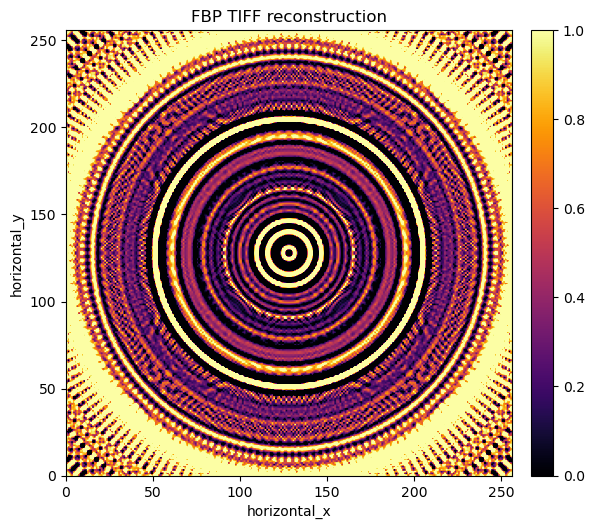

In [145]:
# Setup and run the FBP algorithm
#fbp_recon_NEXUS = FBP(ig, ag,  device = 'cpu')(data) # data # sinoNEXUS # dataNEXUS
fbp_recon_TIFF = FBP(ig, ag,  device = 'cpu')(dataTIFF)

# Show reconstructions
#show2D([fbp_recon_NEXUS, fbp_recon_TIFF], 
#       title = ['FBP NEXUS reconstruction', 'FBP TIFF reconstruction'], 
#       cmap = 'inferno', fix_range=(0,1.), size=(10,10))
show2D([fbp_recon_TIFF], 
       title = ['FBP TIFF reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

#assert dataTIFF.geometry == dataNEXUS.geometry

In the above reconstruction noise is not penalised. In order to remove noise artifacts, we will use the TotalVariation regularisation as shown in the minimisation problem above.

We solve [(1)](#tv_reg), using the **Primal-Dual Hybrid Gradient (PDHG)** algorithm introduced in [ChambollePock](https://link.springer.com/article/10.1007/s10851-010-0251-1). We need to write [(1)](#tgv_reg) in the following general form $$\underset{x\in \mathbb{X} }{\operatorname{argmin}} f(Kx) + g(x).$$

We let $x=u$ and

* define an operator $K:\mathbb{X}\rightarrow\mathbb{Y}$ as$\\[10pt]$

    $$\begin{equation}
    K = 
    \begin{bmatrix}
    A \\
    D 
    \end{bmatrix} \quad\Rightarrow\quad
    Kx = Ku = 
    \begin{bmatrix}
    \mathcal{A}u\\
    Du\\
    \end{bmatrix} =
    \begin{bmatrix}
    y_{1}\\
    y_{2}
    \end{bmatrix} = y\in \mathbb{Y},
    \label{def_K}
    \end{equation}$$ 
    
* define a function $f:\mathbb{Y}\rightarrow\mathbb{R}$ as$\\[10pt]$

    $$\begin{equation}
    \begin{aligned}
    & f(y)  := f(y_{1}, y_{2}) = f_{1}(y_{1}) +  f_{2}(y_{2}) , \mbox{ where},\\[10pt]
    & f_{1}(y_{1}) :=  \frac{1}{2}\| y_{1} - g\|_{2}^{2},\, f_{2}(y_{2}) :=  \alpha \|y_{2}\|_{2,1}
    \end{aligned}
    \label{def_f}
    \end{equation}\\[10pt]$$
    
* and define a function $g(x) = g(u) = \mathbb{I}_{\{u\geq0\}}(u)$ for the non-negativity constraint.



# CGLS

  0%|          | 0/30 [00:00<?, ?it/s]

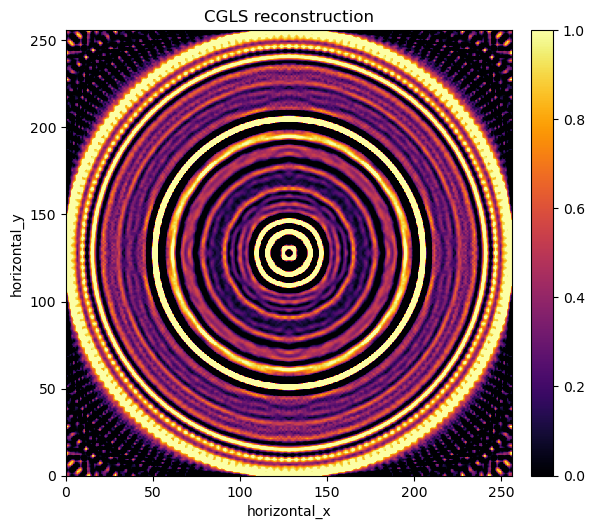

In [141]:
A = ProjectionOperatorAstra(ig, ag, "gpu")
#A = ProjectionOperatorAstra(ig, ag, '2D')

initial = ig.allocate(0)

cgls = CGLS(initial=initial,
            operator=A,
            data=dataTIFF,
            max_iteration = 1000,
            update_objective_interval = 1 )

cgls.run(30)

recon_cgls = cgls.solution
    
show2D([recon_cgls], 
       title = ['CGLS reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))
    

# SIRT

  0%|          | 0/30 [00:00<?, ?it/s]

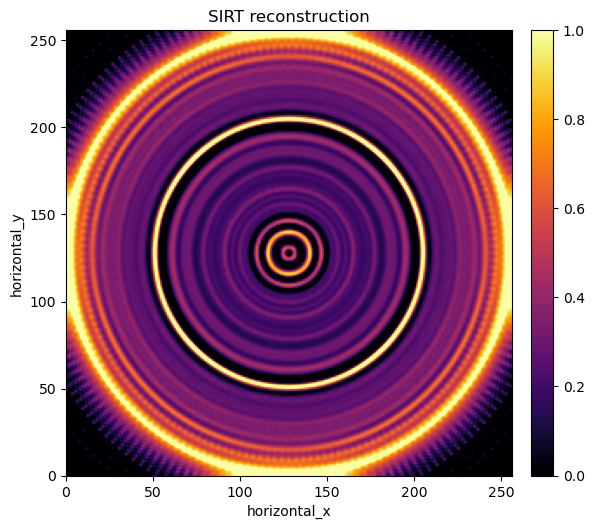

In [142]:
constraint = IndicatorBox(lower=0)

sirt = SIRT(initial=initial,
            operator=A,
            data=dataTIFF,
            constraint=constraint,
            max_iteration = 1000)

sirt.update_objective_interval=1

sirt.run(30)

recon_sirt = sirt.solution
    
show2D([recon_sirt], 
       title = ['SIRT reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

# PDHG

  0%|          | 0/30 [00:00<?, ?it/s]

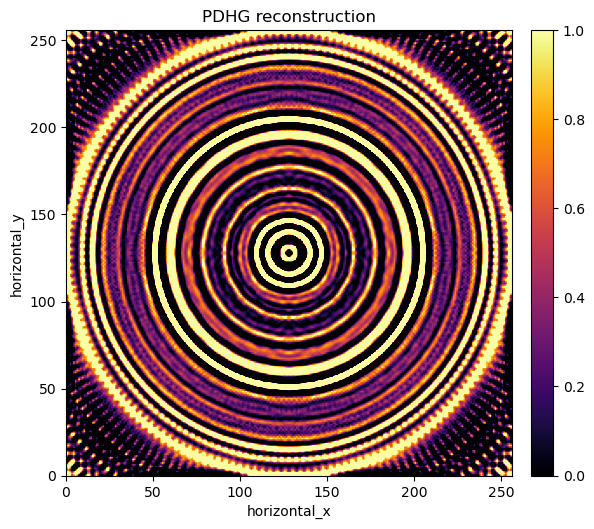

In [143]:
F = 1000 * L2NormSquared(b=dataTIFF)
G = 0.005 * L1Norm()

pdhg_l1 = PDHG(
    f = F,
    g = G,
    operator = A,
    max_iteration = 1000,
    update_objective_interval=1
)

pdhg_l1.run(30)

recon_pdhg = pdhg_l1.solution

show2D([recon_pdhg], 
       title = ['PDHG reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

In [144]:
# Define BlockOperator K
Grad = GradientOperator(ig)
K = BlockOperator(A, Grad)

# Define BlockFunction f
alpha = 0.1
f1 = 0.5 * L2NormSquared(b=sino)
f2 = alpha * MixedL21Norm()
f = BlockFunction(f1, f2)

# Define Function g
g = IndicatorBox(lower=0)

# Primal/Dual stepsizes
normK = K.norm()
sigma = 1./normK
tau = 1./normK

# Setup and run PDHG
pdhg = PDHG(f = f, g = g, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 200,
            update_objective_interval = 50)
pdhg.run(verbose=2)

NameError: name 'sino' is not defined

Finally, we compare the PDHG and FBP reconstructions and plot the middle line profiles.

In [ ]:
show2D([pdhg.solution,fbp_recon, phantom], title = ['TV regularisation','FBP','Ground Truth'], cmap = 'inferno', num_cols=3, fix_range=(0,1.))

# Plot middle line profile
plt.figure(figsize=(30,15))
plt.plot(phantom.get_slice(horizontal_y = int(N/2)).as_array(), label = 'Ground Truth', linewidth=5)
plt.plot(fbp_recon.get_slice(horizontal_y = int(N/2)).as_array(), label = 'FBP', linewidth=5, linestyle='dashed')
plt.plot(pdhg.solution.get_slice(horizontal_y = int(N/2)).as_array(), label = 'TV', linewidth=5)
plt.legend()
plt.title('Middle Line Profiles')
plt.show()